### Backtest MACD for Nifty50

### Imports & Settings

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import dtale
idx = pd.IndexSlice

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import investpy
import pyfolio as pf
import backtrader as bt
import collections
from scipy.stats import linregress

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pyfolio\pos.py:26: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



In [4]:
sns.set_style('whitegrid')
np.random.seed(42)
bt.__version__

'1.9.76.123'

In [5]:
fromdate=datetime.datetime(2020, 12, 1)
todate=datetime.datetime(2021, 1, 27)

In [6]:
ticker = '^NSEI' #'NIFTY 50'

In [7]:
columns = ['Adj Close','High','Low','Open','Volume']
stock = yf.download(ticker, start="2020-12-01", end="2021-01-27", interval = "15m")[columns] # 1m, 5m, 15m, 30m, 45m, 60m
# stock = yf.download(ticker,progress=True, interval='1m')[columns]
stock.columns = ['close','high','low','open','volume']
stock.tail()

[*********************100%***********************]  1 of 1 completed


,close,high,low,open,volume
Datetime,,,,,
2021-01-25 14:15:00+05:30,14275.450195,14322.750000,14272.250000,14316.700195,0
2021-01-25 14:30:00+05:30,14296.450195,14308.500000,14260.150391,14275.950195,0
2021-01-25 14:45:00+05:30,14267.150391,14305.150391,14263.599609,14296.700195,0
2021-01-25 15:00:00+05:30,14238.150391,14277.549805,14224.400391,14267.849609,0
2021-01-25 15:15:00+05:30,14247.950195,14251.750000,14219.400391,14240.500000,0


In [8]:
# stock = investpy.get_index_historical_data(ticker,country='India',from_date='01/01/2000',
#                                         to_date='21/01/2027')
# stock = stock.sort_values(by='Date', ascending=True)
# stock = stock[~stock.index.duplicated()]
# stock.index.name = 'date'
# stock = stock.drop('Currency', axis=1)
# stock.rename(columns = {'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}, inplace=True)
# stock.head()

In [9]:
stock.index[-1].time()

datetime.time(15, 15)

In [10]:
dtale.show(stock, ignore_duplicate=True)

In [11]:
BTVERSION = tuple(int(x) for x in bt.__version__.split('.'))

In [12]:
class FixedPerc(bt.Sizer):
    '''This sizer simply returns a fixed size for any operation
    Params:
      - ``perc`` (default: ``0.20``) Perc of cash to allocate for operation
    '''

    params = (
        ('perc', 0.20),  # perc of cash to use for operation
    )

    def _getsizing(self, comminfo, cash, data, isbuy):
        cashtouse = self.p.perc * cash
        if BTVERSION > (1, 7, 1, 93):
            size = comminfo.getsize(data.close[0], cashtouse)
        else:
            size = cashtouse // data.close[0]
        return size

In [13]:
print(datetime.time(9, 15))

09:15:00


In [65]:
class TheStrategy(bt.Strategy):
    '''
    This strategy is loosely based on some of the examples from the Van
    K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:
      - Enter the market if:
        - The MACD.macd line crosses the MACD.signal line to the upside
        - The Simple Moving Average has a negative direction in the last x
          periods (actual value below value x periods ago)
     - Set a stop price x times the ATR value away from the close
     - If in the market:
       - Check if the current close has gone below the stop price. If yes,
         exit.
       - If not, update the stop price if the new stop price would be higher
         than the current
    '''

    params = (
        # Standard MACD Parameters
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atrperiod', 14),  # ATR Period (standard)
        ('atrdist', 3.0),   # ATR distance for stop price
        ('smaperiod', 30),  # SMA Period (pretty standard)
        ('dirperiod', 10),  # Lookback period to consider SMA trend direction
        ('printlog', True)
    )
    
    def log(self, txt, dt=None, doprint=False):
        ''' Logging function '''
        if self.params.printlog:
            dt = dt or self.data.datetime[0]
            if isinstance(dt, float):
                dt = bt.num2date(dt)
            print("%s, %s" % (dt.isoformat(), txt))

    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price, order.executed.value, order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value,order.executed.comm))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
            
    def __init__(self):
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

        # To set the stop price
        self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

        # Control market trend
        self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
        self.smadir = self.sma - self.sma(-self.p.dirperiod)
        
    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order
        
    def next(self):
        if self.order:
            return  # pending order execution
        
        time0 = self.datas[0].datetime.time(0)
        is_between = datetime.time(9, 15) <= time0 <= datetime.time(15, 30)
#         print('self.data.datetime[0] ', self.datas[0].datetime.time(0))
#         if not is_between:
#             return

        if not self.position:  # not in the market
            if self.mcross[0] > 0.0 and self.smadir < 0.0:
                if datetime.time(9, 15) <= time0 <= datetime.time(15, 30):
                    self.order_target_percent(data, target=0.95)
                    self.log('Buy {}'.format(data._name)) 
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] - pdist

        else:  # in the market
            pclose = self.data.close[0]
            pstop = self.pstop

            if pclose < pstop:
                if datetime.time(9, 15) <= time0 <= datetime.time(15, 30):
                    self.close()  # stop met - get out
                    self.log('Sell {}'.format(data._name)) 

            else:
                pdist = self.atr[0] * self.p.atrdist
                # Update only if greater than
                self.pstop = max(pstop, pclose - pdist)   

In [79]:
# Model Settings
startcash = 100000
macd1 = 12
macd2 = 26
macdsig =  9
atrperiod = 14  # ATR Period (standard)
atrdist = 3.0   # ATR distance for stop price
smaperiod = 30  # SMA Period (pretty standard)
dirperiod = 10  # Lookback period to consider SMA trend direction


# Commission %
commission = 0.00

In [80]:
cerebro = bt.Cerebro()
cerebro.broker.setcommission(commission=commission)
cerebro.broker.setcash(startcash)

In [81]:
data = bt.feeds.PandasData(dataname=stock, name=ticker,
#                                    fromdate=fromdate,
#                                    todate=todate,
                                    timeframe=bt.TimeFrame.Minutes, compression=15,
                                    sessionstart=datetime.time(9, 15), sessionend=datetime.time(15, 30),
                                    plot=True)
cerebro.adddata(data)

In [82]:
cerebro.addstrategy(TheStrategy,
                        macd1=macd1, macd2=macd2,
                        macdsig=macdsig,
                        atrperiod=atrperiod,
                        atrdist=atrdist,
                        smaperiod=smaperiod,
                        dirperiod=dirperiod)

0

In [83]:
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [84]:
%%time
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the strategy. Results will be output from stop.
results = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2020-12-02T09:15:00, Buy ^NSEI
2020-12-02T09:30:00, BUY EXECUTED, Price: 13099.45, Cost: 91696.15, Comm 0.00
2020-12-10T09:30:00, Sell ^NSEI
2020-12-10T09:45:00, SELL EXECUTED, Price: 13471.25, Cost: 91696.15, Comm 0.00
2021-01-13T09:45:00, Buy ^NSEI
2021-01-14T03:45:00, BUY EXECUTED, Price: 14550.05, Cost: 87300.30, Comm 0.00
2021-01-15T09:15:00, Sell ^NSEI
2021-01-15T09:30:00, SELL EXECUTED, Price: 14441.30, Cost: 87300.30, Comm 0.00
Final Portfolio Value: 101950.10
Wall time: 485 ms


<IPython.core.display.Javascript object>


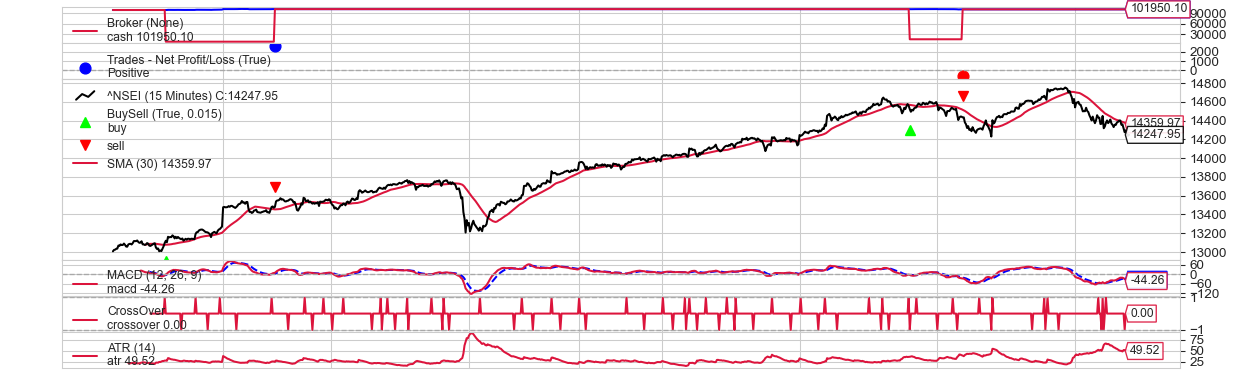

[[<Figure size 432x288 with 7 Axes>]]

In [85]:
cerebro.plot()